In [ ]:
%run LanguageModel.py
%run DataLoader.py
%run rnn_utils.py
%run encoder.py
%run decoder.py
%run seq2seq.py
%run model_config.py
%run metrics.py
%run ScorePrinter.py
import numpy as np
import math
import json

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MAX_LENGTH = 50

In [ ]:
train_dl = DataLoader('train', ('de', 'en'), max_length = MAX_LENGTH, filter_token = 10, device = device)
val_dl = DataLoader('dev', ('de', 'en'), languageModels = train_dl.languageModels, max_length = MAX_LENGTH, device = device)

In [ ]:
lm1 = train_dl.languageModels[train_dl.languages[0]]
lm2 = train_dl.languageModels[train_dl.languages[1]]
model_config = ModelConfig(input_size = lm1.n_tokens, 
                           beam_width = 3, 
                           hidden_size = 50, 
                           output_size = lm2.n_tokens, 
                           rnn_type='lstm', 
                           bidirectional = True,
                           bidirectional_type='concat', 
                           attention = 'global_context', 
                           score = 'dot', 
                           learning_rate = 3 * 10**(-4),
                           max_length=MAX_LENGTH+2) # +2 for SOS and EOS
#checkpoint = None 
checkpoint = torch.load("./state_dict_fast_25.tar", map_location='cpu')
s2s = seq2seq(model_config=model_config, state_dict = checkpoint, device = device)

In [ ]:
def validate(n = None):
    score_printer = ScorePrinter("Validation", [('NLL normalized', loss_metric),('Perplexity', perplexity)]) #('BLEU', bleu)
    n = n or len(val_dl)
    idx_permutation_val = np.random.permutation(len(val_dl))[:n]
    score_printer.beginMeasurements()
    for j, val_index in enumerate(idx_permutation_val):
        input_tensor_val, target_tensor_val = val_dl.tensorsFromPos(val_index)
        loss, output_sentence = s2s.evaluate(input_tensor_val, target_tensor_val)
        real_target_sentence, estimated_target_sentence = val_dl.real_estimated_sentence(target_tensor_val, output_sentence)
        print(f"real : {real_target_sentence}, est : {estimated_target_sentence}")
        score_printer.update(nll = loss, target_length = target_tensor_val.size(0), real_target_sentence  = real_target_sentence, estimated_target_sentence = estimated_target_sentence)
    score_printer.printAvg(showCount = False)
    return score_printer.getAvgScores()

In [ ]:
test_dl = DataLoader('test', ('de', 'en'), languageModels = train_dl.languageModels, max_length = MAX_LENGTH, device = device)

In [ ]:
#For network evaluation:
def evaluation():
    score_printer = ScorePrinter("Validation", [('NLL normalized', loss_metric),('Perplexity', perplexity),('BLEU', bleu)])
    idx_permutation_val = np.random.permutation(len(test_dl))
    score_printer.beginMeasurements()
    for j, test_index in enumerate(idx_permutation_val):
        input_tensor_val, target_tensor_val = test_dl.tensorsFromPos(test_index)
        loss, output_sentence = s2s.evaluate(input_tensor_val, target_tensor_val)
        real_target_sentence, estimated_target_sentence = test_dl.real_estimated_sentence(target_tensor_val, output_sentence)
        score_printer.update(nll = loss, target_length = target_tensor_val.size(0), real_target_sentence  = real_target_sentence, estimated_target_sentence = estimated_target_sentence)
    score_printer.printAvg(showCount = False)
    evaluation_scores = score_printer.getAvgScores()
    with open('./evaluation_scores.txt', 'a') as evaluation_file:
        evaluation_file.write(json.dumps(evaluation_scores))
    
evaluation()

In [22]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker

def show_attention(input_sentence, output_sentence, attentions):
    # Set up figure with colorbar
    fig = plt.figure(figsize=(16, 14), dpi= 40)
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions, cmap='bone')
    fig.colorbar(cax)
    
    ax.set_xticks(np.arange(len(input_sentence)))
    ax.set_xticklabels(input_sentence, rotation=90)
    ax.set_yticks(np.arange(len(output_sentence[1:])))
    ax.set_yticklabels(output_sentence[1:]) # ignore SOS Token

    plt.show()
    fig = matplotlib.pyplot.gcf()
    fig.savefig('Attention.png', dpi=100)

In [23]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import matplotlib
%matplotlib inline
from IPython.display import display, Markdown
def print_validation_custom(input_sentence):
    display(Markdown('**Eingabe**'))
    display(Markdown(input_sentence))
    input_sentence = input_sentence.split(" ")
    input_tensor = train_dl._tensorFromSentence(train_dl.languageModels[train_dl.languages[0]], input_sentence)
    prediction = s2s.predict(input_tensor)
    output_sentence = train_dl.sentenceFromTensor('en', prediction[0])
    display(Markdown('**Ausgabe**'))
    display(Markdown(" ".join(output_sentence)))
    attentions = torch.stack([tensor.squeeze() for tensor in prediction[2]])
    attentions = attentions.numpy()[:len(output_sentence)-1,:len(input_sentence)]
    display(Markdown('**Attention**'))
    show_attention(input_sentence, output_sentence, attentions)

**Eingabe**

wir halten diese präsentation um unsere ergebnisse vorzustellen

**Ausgabe**

SOS we think this presentation is to to to EOS

**Attention**

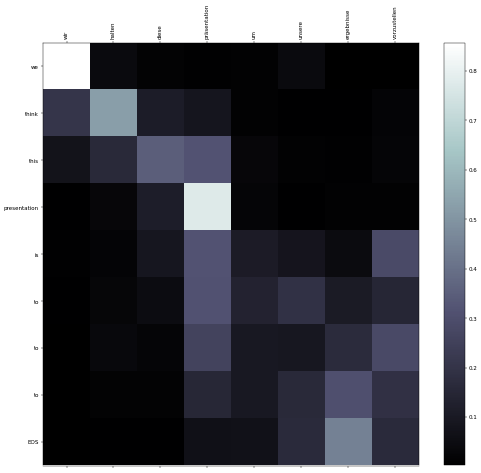

<Figure size 432x288 with 0 Axes>

In [24]:
my_sentence = "wir halten diese präsentation um unsere ergebnisse vorzustellen"

print_validation_custom(input_sentence=my_sentence)

In [25]:
import matplotlib
from IPython.display import display, Markdown
def print_validation(position):
    input_sentence = val_dl.sentenceFromTensor('de', val_dl.tensorsFromPos(position)[0])
    display(Markdown('**Eingabe**'))
    display(Markdown(' '.join(input_sentence)))
    prediction = s2s.predict(val_dl.tensorsFromPos(position)[0])
    output_sentence = val_dl.sentenceFromTensor('en', prediction[0])
    display(Markdown('**Ausgabe**'))
    display(Markdown(' '.join(output_sentence)))
    attentions = torch.stack([tensor.squeeze() for tensor in prediction[2]])
    attentions = attentions.numpy()[:len(output_sentence)-1,:len(input_sentence)]
    display(Markdown('**Attention**'))
    show_attention(input_sentence, output_sentence, attentions)

**Eingabe**

und dann würden sie plötzlich erkennen , wie es wäre , wenn sie ihre eigene sprache nicht sprechen könnten . EOS

**Ausgabe**

SOS and then you would recognize it , as it would be able to talk about their own language . EOS

**Attention**

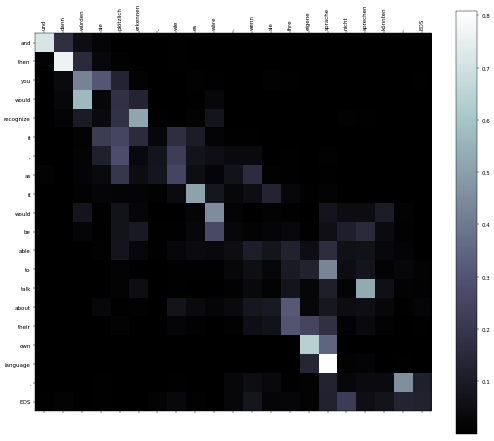

<Figure size 432x288 with 0 Axes>

In [26]:
print_validation(32) 